#### Propose : 주가 예측에 도움될 만한 Feature 찾아보기
#### How : 네이버 종목 게시판의 개인 의견 탐색적 분석
#### 참가자
1. 미래에셋대우 : 강민구 자산관리전문가, 이규남 빅데이터 신입
2. 미래에셋생명 : 손예진 보험계리전문가, 김문환 CFC영업지원전문가

# 초안 : 사전 사용

In [1]:
import requests
from bs4 import BeautifulSoup
import json
import time
import re
import pandas as pd
import numpy as np 
import os 

In [2]:
#종목코드 
url = "http://comp.fnguide.com/XML/Market/CompanyList.txt"
resp = requests.get(url)
json_data = resp.content

my_dic = json.loads(json_data, strict=False)
data = my_dic['Co']

codes = pd.DataFrame()
for i in range(0, len(data)):
    d = {'code' : [data[i]['cd'][1:len(data[i]['cd'])]],
         'name' : [data[i]['nm']]}
    temp = pd.DataFrame(d)
    codes = pd.concat([temp, codes], axis = 0)
codes = codes.reset_index().drop('index', axis=1)
codes.head()

,code,name
0,500023,신한 콩 선물 ETN(H)
1,500039,신한 코스피 콘도르 4/10% ETN
2,500021,신한 천연가스 선물 ETN(H)
3,500024,신한 인버스 콩 선물 ETN(H)
4,500022,신한 인버스 천연가스 선물 ETN(H)


In [106]:
def deep_crawl(url):
    try:
        resp = requests.get(str(url))
        html = resp.text

        soup = BeautifulSoup(html, "html5lib")
        temp = soup.select("#body")
        return temp[0].text
    except:
        return 0

def crawl(code, page):
    try :
        time.sleep(2)

        url = "https://finance.naver.com/item/board.nhn?code="+code+"&page="+str(page)
        resp = requests.get(url)
        html = resp.text

        soup = BeautifulSoup(html, "html5lib")

        deep_url=[]
        for anchor in soup.findAll('a', href=re.compile("^(/item/board_read.nhn?)")):
            deep_url.append(anchor['href'])

        opinion = soup.select("#content > div.section.inner_sub > table.type2 > tbody > tr > td.tc > span")
        rec_count = soup.select("#content > div.section.inner_sub > table.type2 > tbody > tr > td > strong")
        sec_count = soup.select("#content > div.section.inner_sub > table.type2 > tbody > tr > td > span.tah")
        date = soup.select("#content > div.section.inner_sub > table.type2 > tbody > tr > td > span.tah")

        temp = []
        for i in range(0, len(date)):
            if(i%2==0):
                temp.append(date[i].text)
        date = temp

        temp = []
        for i in range(0, len(sec_count)):
            if(i%2!=0):
                temp.append(sec_count[i].text)
        sec_count = temp

        df = pd.DataFrame()
        for i in range(0, len(date)):
            temp = str(page) + "번째 페이지의 "+str(i)+"번째_게시글"
            d = {'rank' : [temp],
                 'date' : [date[i]],
                 'opinion': [opinion[i].text],
                 'description' : [deep_crawl("https://finance.naver.com"+deep_url[i])],
                 'rec': [rec_count[i].text], 
                 'click_count': [sec_count[i]]}

            temp = pd.DataFrame(d)
            df = pd.concat([temp, df],axis=0)
        return df.reset_index().drop(['index'], axis= 1)
    except:
        return 0

In [79]:
df = pd.DataFrame()
for i in range(2500,2502):
    print("\n종목명 : %s"%codes['name'].iloc[i])
    for j in range(1,3):
        print("%d 번째 페이지 크롤링 중..."%j)
        temp = crawl(codes['code'].iloc[i],str(j))
        df = pd.concat([temp,df], axis= 0)


종목명 : 덕산하이메탈
1 번째 페이지 크롤링 중...
2 번째 페이지 크롤링 중...

종목명 : 덕산네오룩스
1 번째 페이지 크롤링 중...
2 번째 페이지 크롤링 중...


In [7]:
df.head()

,click_count,date,description,opinion,rank,rec,code
0,88,2018.11.23 20:14,ㅎㅎㅎ 뭐가 있네 있어 ㅋ,의견없음,1번째 페이지의 19번째_게시글,0,234100
0,104,2018.11.23 20:14,ㅋㅋㅋㅋ,의견없음,1번째 페이지의 18번째_게시글,0,234100
0,134,2018.11.23 20:14,"세력들 1,500원부터 매집해 지금 마지막 패데기 시점이고\n\n지들끼리 사고 팔고...",의견없음,1번째 페이지의 17번째_게시글,0,234100
0,120,2018.11.23 20:14,뇌동매매 하는 거지같은 개미들아 ^^ \n\n잘먹고 잘간다~\n\n늬들이 있어서 행...,의견없음,1번째 페이지의 16번째_게시글,0,234100
0,172,2018.11.23 20:14,ㅎㅎㅎ,의견없음,1번째 페이지의 15번째_게시글,0,234100


In [51]:
import json

class KnuSL():
    def data_list(wordname):
        with open('C:/Users/user/Desktop/Dev/SentiWord_info.json', encoding='utf-8-sig', mode='r') as f:
                data = json.load(f)
        result = ['None','None']
        for i in range(0, len(data)):
            if data[i]['word'] == wordname:
                result.pop()
                result.pop()
                result.append(data[i]['word_root'])
                result.append(data[i]['polarity'])

        r_word = result[0]
        s_word = result[1]

        return r_word, s_word

In [77]:
ksl = KnuSL

print("\nKNU 한국어 감성사전입니다~ :)")
print("사전에 단어가 없는 경우 결과가 None으로 나타납니다!!!")
print("-2:매우 부정, -1:부정, 0:중립 or Unkwon, 1:긍정, 2:매우 긍정")

wordname = df['description']
result = []
wordname = wordname.apply(lambda x: x.split(' '))
for i in range(0, len(wordname)):
    temp = wordname.iloc[i]
    temp2 = 0
    for j in range(0, len(temp)):
        r_word, s_word = ksl.data_list(temp[j])
        try:
            temp2 = temp2+int(s_word)
        except:
            pass
    result.append(temp2)


KNU 한국어 감성사전입니다~ :)
사전에 단어가 없는 경우 결과가 None으로 나타납니다!!!
-2:매우 부정, -1:부정, 0:중립 or Unkwon, 1:긍정, 2:매우 긍정


In [73]:
result = pd.DataFrame(result)
result.columns = ['Sentiment']

df = df.reset_index().drop(['index'], axis= 1)
df = pd.concat([df, result], axis=1)

In [75]:
df.head()

,click_count,date,description,opinion,rank,rec,code,0
0,88,2018.11.23 20:14,ㅎㅎㅎ 뭐가 있네 있어 ㅋ,의견없음,1번째 페이지의 19번째_게시글,0,234100,0
1,104,2018.11.23 20:14,ㅋㅋㅋㅋ,의견없음,1번째 페이지의 18번째_게시글,0,234100,0
2,134,2018.11.23 20:14,"세력들 1,500원부터 매집해 지금 마지막 패데기 시점이고\n\n지들끼리 사고 팔고...",의견없음,1번째 페이지의 17번째_게시글,0,234100,0
3,120,2018.11.23 20:14,뇌동매매 하는 거지같은 개미들아 ^^ \n\n잘먹고 잘간다~\n\n늬들이 있어서 행...,의견없음,1번째 페이지의 16번째_게시글,0,234100,5
4,172,2018.11.23 20:14,ㅎㅎㅎ,의견없음,1번째 페이지의 15번째_게시글,0,234100,0


# 비꼬는 것 때문에 급 선회
#### 강민구 자산관리전문가의 경험 및 조언 : 
#### 바이럴이 많은 종목을 대상으로 수행 => 셀트리온 선택

# 1. 데이터 준비

In [151]:
#df = pd.DataFrame()
for j in range(0,5000):
    if((j%100)==0):
        print("%d 번째 페이지 크롤링 중..."%j)
    temp = crawl(codes[codes['name'].isin(['셀트리온'])]['code'].values[0],str(j))
    df = pd.concat([temp,df], axis= 0)

In [8]:
print("전체 게시글 : ", len(df))
print("의견이 강력 매수인 게시글 수 : ", len(df[df['opinion']=='강력매수']))
positive = df[df['opinion']=='강력매수']
positive = positive.reset_index().drop('index', axis=1)
print("의견이 강력 매도인 게시글 수 : ", len(df[df['opinion']=='강력매도']))
negative = df[df['opinion']=='강력매도']
negative = negative.reset_index().drop('index', axis=1)

전체 게시글 :  99980
의견이 강력 매수인 게시글 수 :  3132
의견이 강력 매도인 게시글 수 :  1353


In [9]:
positive.head()

,click_count,date,description,opinion,rank,rec
0,968,2018.08.06 08:58,일희일비 의미없다.,강력매수,4983번째 페이지의 13번째_게시글,0
1,727,2018.08.06 09:26,\n한주간 공매도 알바들로부터 네이버 종목토론실을 지켜주시기 위해 애쓰신 주주님들...,강력매수,4982번째 페이지의 14번째_게시글,2
2,623,2018.08.06 09:52,미국 전기자동차 업체 테슬라의 예상치 못한 주가 급등으로 공매도 투자자들이 막대한 ...,강력매수,4981번째 페이지의 8번째_게시글,9
3,647,2018.08.06 09:57,http://www.asiatoday.co.kr/view.php?key=201808...,강력매수,4981번째 페이지의 5번째_게시글,0
4,593,2018.08.06 10:02,http://www.etnews.com/20180803000098?f=o\n\n이베...,강력매수,4981번째 페이지의 2번째_게시글,22


In [5]:
negative.head()

,click_count,date,description,opinion,rank,rec
0,442,2018.08.06 13:08,공매야 갚지 마라\n가열차게 ?궈 주라\n나는 아직 배고프다'\n니들이 떨궈주면 \...,강력매도,4972번째 페이지의 17번째_게시글,1
1,357,2018.08.07 11:13,안티하니 안좋지 그렇닌까 너들도 안티하지말어 애들두아니고 ㅋㅋㅋ,강력매도,4917번째 페이지의 12번째_게시글,3
2,230,2018.08.08 14:41,배아프지롱 ㅋㅋ,강력매도,4850번째 페이지의 4번째_게시글,0
3,598,2018.08.08 16:11,셀트리온은 연결재무제표 기준 2분기 영업이익이 1082억 원으로 전년 동기 대비 2...,강력매도,4836번째 페이지의 15번째_게시글,2
4,305,2018.08.08 16:27,이젠 끝인듯 에혀,강력매도,4833번째 페이지의 6번째_게시글,1


# 2. 단어 임베딩

In [20]:
df.head()

,click_count,date,description,opinion,rank,rec
0,437,2018.08.05 17:02,■ 15퍼폭락할 주식 jong ■ \n\n-----------------------...,매수,4999번째 페이지의 19번째_게시글,1
1,442,2018.08.05 17:00,----------------------------------------------...,매수,4999번째 페이지의 18번째_게시글,6
2,478,2018.08.05 16:58,■ 정신과 의사라는 정신나간 介 ■ \n\n띨띨한 알바 ㅅ ㄲ \n\n왜 더는 할게...,매수,4999번째 페이지의 17번째_게시글,0
3,693,2018.08.05 16:58,이데일리 이명철 기자] 이베스트투자증권은 1일 셀트리온(068270)에 대해 미국 ...,의견없음,4999번째 페이지의 16번째_게시글,2
4,670,2018.08.05 17:01,개투들이 단한주도 내어주지 않고 숏커버 들어가면 무한 우주까지 날아가겠죠\n\n외...,의견없음,4999번째 페이지의 15번째_게시글,1


In [29]:
for i in range(57,60):
    print("실제 남긴 글 : \n", df['description'].iloc[i])
    print("\nunsupervised learning 으로 자른 결과 : \n", cohesion_tokenized_reviews[i])
    print("-"*180)

실제 남긴 글 : 
 바이오시밀러황제주로오시오
500%할인

unsupervised learning 으로 자른 결과 : 
 ['바이오', '시밀러', '황제주', '로', '오시', '오', '50', '0%', '할인']
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
실제 남긴 글 : 
 왜이리 게시판 어지럽네요
정신병자 한마리
짜증나네요  이해불가

unsupervised learning 으로 자른 결과 : 
 ['왜이리', '게시', '판', '어지럽', '네요', '정신병자', '한마', '리', '짜증', '나네요', '이해', '불가']
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
실제 남긴 글 : 
 셀트리온과 미국 나와바리 나눠먹기
화이자  
테바 ~버핏옹 투자
Jp모건
미국정부 재정적자 해소
바이오시밀러활성화정책

존슨앤존슨 분기매출 레미케이드18%하락

unsupervised learning 으로 자른 결과 : 
 ['셀트', '리온', '과', '미국', '나와', '바리', '나눠', '먹기', '화이', '자', '테바', '~', '버핏', '옹', '투자', 'Jp모건', '미국', '정부', '재정', '적자', '해소', '바이오', '시밀러', '활성화', '정책', '존슨앤존슨', '분기', '매출', '레미케이드', '18', '%', '하락']
------------------

# 3. 유사 단어 산출

In [10]:
#생게시판 그대로 넣었을 때 
model = sim_words(cohesiontokenizer, positive,1)
print("positive skip-gram : \n", model.wv.most_similar("매수", topn=10))

model = sim_words(cohesiontokenizer, positive,0)
print("\n positive cbow : \n", model.wv.most_similar("매수", topn=10))

model = sim_words(cohesiontokenizer, negative,1)
print("\n negative skip-gram : \n", model.wv.most_similar("매도", topn=10))

model = sim_words(cohesiontokenizer, negative,0)
print("\n negative cbow : \n", model.wv.most_similar("매도", topn=10))

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


positive skip-gram : 
 [('적기', 0.3881308138370514), ('폭풍', 0.3876667320728302), ('줄때', 0.3868526816368103), ('이므로', 0.3835819661617279), ('저점', 0.37677568197250366), ('대기', 0.36372795701026917), ('분할', 0.3627720773220062), ('기회', 0.3609699010848999), ('세가', 0.358420193195343), ('장대', 0.35259178280830383)]

 positive cbow : 
 [('추매', 0.6007817387580872), ('매도', 0.5097454190254211), ('손절', 0.5091956853866577), ('장대', 0.5068719387054443), ('베팅', 0.4741964340209961), ('매집', 0.45540672540664673), ('저가', 0.45379558205604553), ('초반에', 0.44895416498184204), ('단타', 0.4457896947860718), ('저점', 0.4389745891094208)]

 negative skip-gram : 
 [('전량', 0.4653171896934509), ('상한가', 0.4258188009262085), ('운동', 0.3850417733192444), ('호가', 0.3803289532661438), ('처분', 0.37997257709503174), ('걸어', 0.3719545304775238), ('웃돈', 0.3645820617675781), ('창구', 0.36226704716682434), ('량', 0.35643306374549866), ('거기', 0.35181400179862976)]

 negative cbow : 
 [('전량', 0.7635171413421631), ('매수', 0.7486167550086975), (

In [12]:
def exect_sim_words(tokenizer, pos_word, neg_word, number):
    model = sim_words(tokenizer, positive,0) #cbow
    pos = model.wv.most_similar(pos_word, topn=number)

    model = sim_words(tokenizer, negative,0)
    neg = model.wv.most_similar(neg_word, topn=number)
    
    pos_words = []
    for i in range(0, len(pos)):
        if(pos[i][0]==neg_word):
            pass
        else:
            pos_words.append(pos[i][0])

    neg_words = []
    for i in range(0, len(neg)):
        if(neg[i][0]==pos_word):
            pass
        else:
            neg_words.append(neg[i][0])
    
    return pos_words, neg_words

In [13]:
pos_words, neg_words = exect_sim_words(cohesiontokenizer, "매수", "매도", 11)
print(pos_words)
print(neg_words)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


['추매', '손절', '저가', '매집', '초반에', '장대', '살짝', '분할', '무시', '탑승']
['전량', '상한가', '기회', '저점', '아침', '걸어', '탈출', '처분', '내일', '재']


# 4. 간단 시각화

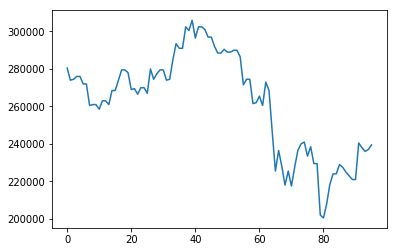

In [15]:
import FinanceDataReader as fdr

sel = fdr.DataReader('068270', '2018.08.05') # 셀트리온, 2018.08.05~현재
sel = sel.reset_index()
sel['Close'].plot()

In [16]:
sel.head()

,Date,Close,Open,High,Low,Volume,Change
0,2018-08-05,280500,280500,280500,280500,0.0,0.0000
1,2018-08-06,274000,280500,283000,272500,377710.0,-0.0232
2,2018-08-07,274500,271500,278000,262500,1100000.0,0.0018
3,2018-08-08,276000,276500,281500,275500,464820.0,0.0055
4,2018-08-09,276000,267000,276000,263500,1070000.0,0.0000


In [108]:
def contains(tokenizer, pos_word, neg_word, number):
    pos_words, neg_words = exect_sim_words(tokenizer, pos_word, neg_word, number)

    temp = pd.DataFrame()
    temp3 = pd.DataFrame()
    for i in range(0, len(cohesion_tokenized_reviews)):
        if (any(elem in pos_words  for elem in cohesion_tokenized_reviews[i])>0):
            temp2 = pd.DataFrame([1])
            temp= pd.concat([temp,temp2], axis=0)
        else:
            temp2 = pd.DataFrame([0])
            temp= pd.concat([temp,temp2], axis=0)
        if(any(elem in neg_words  for elem in cohesion_tokenized_reviews[i])>0):
            temp2 = pd.DataFrame([1])
            temp3= pd.concat([temp3,temp2], axis=0)
        else:
            temp2 = pd.DataFrame([0])
            temp3= pd.concat([temp3,temp2], axis=0)

    temp = temp.reset_index().drop('index', axis=1)
    temp.columns = ['pos_'+str(number)]
    
    temp3 = temp3.reset_index().drop('index', axis=1)
    temp3.columns = ['neg_'+str(number)]

    temp = pd.concat([temp,temp3], axis=1)
    
    return temp

df = df.reset_index().drop('index', axis=1)
df['Date'] = df['date'].str[0:10]

number = [2, 6, 11, 21, 51, 101, 1001]
for i in range(0, len(number)):
    print("doing concat number %d..." %number[i])
    temp = contains(cohesiontokenizer, "매수", "매도", number[i])
    df = pd.concat([df, temp], axis=1)

doing concat number 2...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


doing concat number 6...
doing concat number 11...
doing concat number 21...
doing concat number 51...
doing concat number 101...
doing concat number 1001...


In [109]:
df.head()

,click_count,date,description,opinion,rank,rec,Date,pos_2,neg_2,pos_6,...,pos_11,neg_11,pos_21,neg_21,pos_51,neg_51,pos_101,neg_101,pos_1001,neg_1001
0,437,2018.08.05 17:02,■ 15퍼폭락할 주식 jong ■ \n\n-----------------------...,매수,4999번째 페이지의 19번째_게시글,1,2018.08.05,0,0,0,...,0,1,0,1,1,1,1,1,1,1
1,442,2018.08.05 17:00,----------------------------------------------...,매수,4999번째 페이지의 18번째_게시글,6,2018.08.05,0,0,0,...,0,0,1,1,1,1,1,1,1,1
2,478,2018.08.05 16:58,■ 정신과 의사라는 정신나간 介 ■ \n\n띨띨한 알바 ㅅ ㄲ \n\n왜 더는 할게...,매수,4999번째 페이지의 17번째_게시글,0,2018.08.05,0,0,0,...,0,1,0,1,0,1,1,1,1,1
3,693,2018.08.05 16:58,이데일리 이명철 기자] 이베스트투자증권은 1일 셀트리온(068270)에 대해 미국 ...,의견없음,4999번째 페이지의 16번째_게시글,2,2018.08.05,0,0,0,...,0,0,0,0,0,1,1,1,1,1
4,670,2018.08.05 17:01,개투들이 단한주도 내어주지 않고 숏커버 들어가면 무한 우주까지 날아가겠죠\n\n외...,의견없음,4999번째 페이지의 15번째_게시글,1,2018.08.05,0,0,0,...,0,0,0,0,0,0,1,1,1,1


In [114]:
temp = df.groupby(['Date'])['click_count'].count()
temp = temp.reset_index()
temp.columns = ['Date', 'upload_count']

In [119]:
data = df.groupby(['Date'])['pos_2','neg_2','pos_6','neg_6', 'pos_11','neg_11','pos_21','neg_21','pos_51','neg_51','pos_101','neg_101','pos_1001','neg_1001'].sum()
data = data.reset_index()
data = data.merge(temp, on ='Date', how= 'left')
data['Date'] = data['Date'].str.replace('.','-')
sel['Date'] = sel['Date'].astype('str')
sel['Date'] = sel['Date'].str[0:10]

In [120]:
result = data.merge(sel, on ='Date')
result.head()

,Date,pos_2,neg_2,pos_6,neg_6,pos_11,neg_11,pos_21,neg_21,pos_51,...,neg_101,pos_1001,neg_1001,upload_count,Close,Open,High,Low,Volume,Change
0,2018-08-05,9,1,18,8,26,29,36,86,57,...,122,179,184,236,280500,280500,280500,280500,0.0,0.0000
1,2018-08-06,42,0,50,31,78,77,101,130,175,...,329,594,582,752,274000,280500,283000,272500,377710.0,-0.0232
2,2018-08-07,124,2,141,67,186,102,225,210,332,...,591,1068,1075,1365,274500,271500,278000,262500,1100000.0,0.0018
3,2018-08-08,89,3,108,98,160,158,204,318,356,...,660,1522,1514,1949,276000,276500,281500,275500,464820.0,0.0055
4,2018-08-09,121,11,159,194,220,245,293,360,443,...,799,1634,1616,1994,276000,267000,276000,263500,1070000.0,0.0000


In [5]:
result.to_pickle("D:/★사용자 폴더/Desktop/fianl_result_tag.pickle")

In [18]:
result = pd.read_pickle("D:/★사용자 폴더/Desktop/fianl_result_tag.pickle")
df = pd.read_pickle("D:/★사용자 폴더/Desktop/result_tag.pickle")

In [19]:
df= df.iloc[:,0:7]
df['Date'] = df['Date'].str.replace('.','-')

In [20]:
df['opinion'] = df['opinion'].replace('강력매수', 2)
df['opinion'] = df['opinion'].replace('매수', 1)
df['opinion'] = df['opinion'].replace('의견없음', 0)
df['opinion'] = df['opinion'].replace('중립', 0)
df['opinion'] = df['opinion'].replace('매도', -1)
df['opinion'] = df['opinion'].replace('강력매도', -2)

df['click_count'] = df['click_count'].astype('int')
df['rec'] = df['rec'].astype('int')
df['opinion'] = df['opinion'].astype('int')

In [17]:
sel['Date'] = sel['Date'].astype('str')
sel['Date'] = sel['Date'].str[0:10]

In [21]:
df = df.groupby(['Date'])['click_count','rec','opinion'].sum()
df = df.reset_index()
df = df.merge(sel, on='Date', how='left')

In [22]:
df.head()

,Date,click_count,rec,opinion,Close,Open,High,Low,Volume,Change
0,2018-08-05,129999,1462,64,280500.0,280500.0,280500.0,280500.0,0.0,0.0000
1,2018-08-06,429024,5264,79,274000.0,280500.0,283000.0,272500.0,377710.0,-0.0232
2,2018-08-07,590905,7705,185,274500.0,271500.0,278000.0,262500.0,1100000.0,0.0018
3,2018-08-08,638942,7545,193,276000.0,276500.0,281500.0,275500.0,464820.0,0.0055
4,2018-08-09,717978,8255,310,276000.0,267000.0,276000.0,263500.0,1070000.0,0.0000


In [47]:
def graphcal_nomal(table, columns, string, color, label_color):
    import matplotlib.pyplot as plt
    from scipy.ndimage import gaussian_filter

    fig, ax1 = plt.subplots()    

    ax1.plot(table['Close'], 'b-')
    ax1.set_xlabel('period')
    ax1.set_ylabel('price', color='b')

    ax2 = ax1.twinx()
    value = gaussian_filter(table[columns].astype('int'), sigma=2, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
    ax2.plot(value, color)
    ax2.set_ylabel(string, color=label_color)

    fig.set_figheight(8)
    fig.set_figwidth(15)
    plt.show()

In [48]:
df.fillna(method='ffill', inplace=True)

# 5. 최종결과

## 주가와 일자별 클릭 수 합 plot

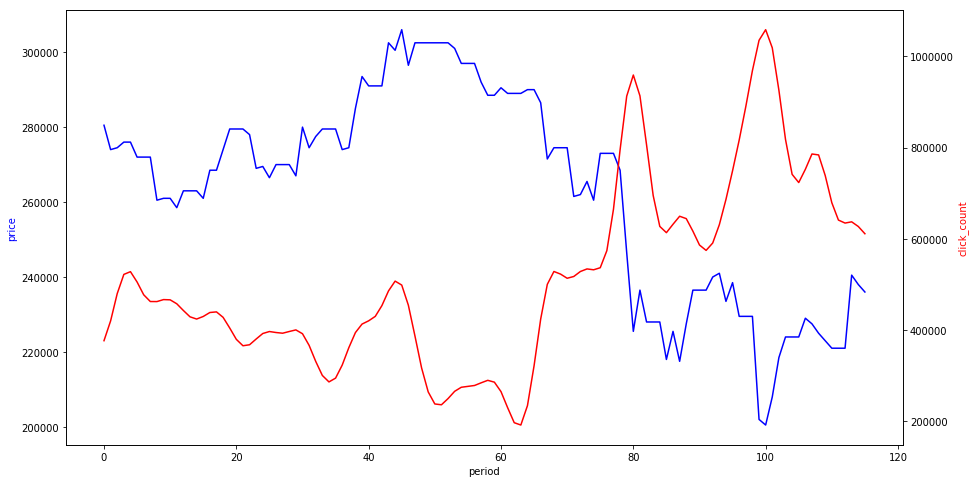

In [49]:
graphcal_nomal(df, 'click_count', 'click_count','r-','r') 

## 주가와 일자별 추천 수 합 plot

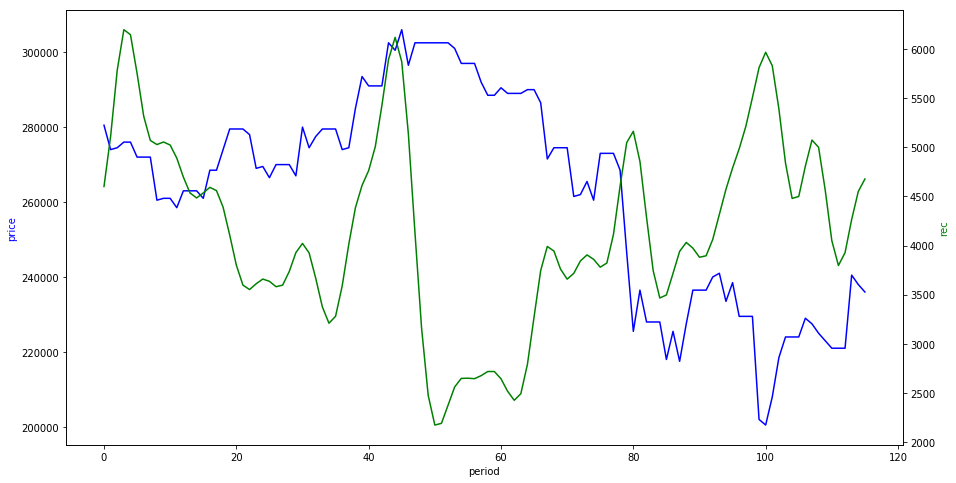

In [50]:
graphcal_nomal(df, 'rec', 'rec','g-','g')

## 주가와 의견 수 합 plot

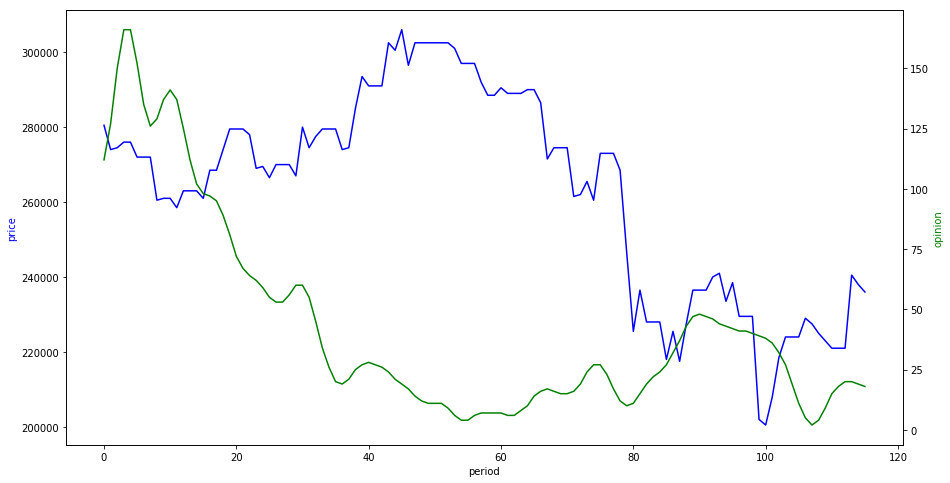

In [51]:
graphcal_nomal(df, 'opinion', 'opinion','g-','g')

In [77]:
def graphcal(table, columns, string, color, label_color):
    import matplotlib.pyplot as plt
    from scipy.ndimage import gaussian_filter

    fig, ax1 = plt.subplots()    

    ax1.plot(table['Close'], 'b-')
    ax1.set_xlabel('period')
    ax1.set_ylabel('price', color='b')

    ax2 = ax1.twinx()
    value = gaussian_filter(table[columns].astype('int')/table['upload_count'].astype('int'), sigma=5, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
    ax2.plot(value, color)
    ax2.set_ylabel(string, color=label_color)

    fig.set_figheight(8)
    fig.set_figwidth(15)
    plt.show()

## 주가와 긍/부정 연관 글자 수 2개 포함 게시글 수 plot

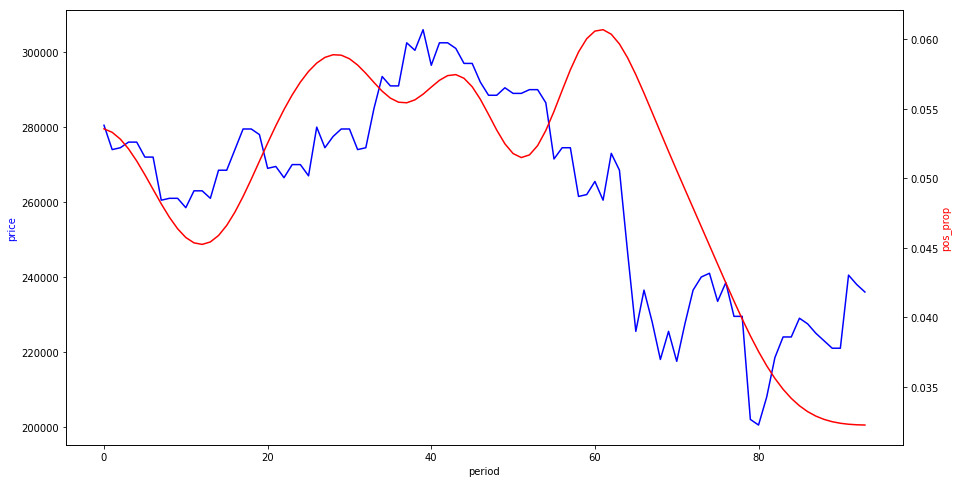

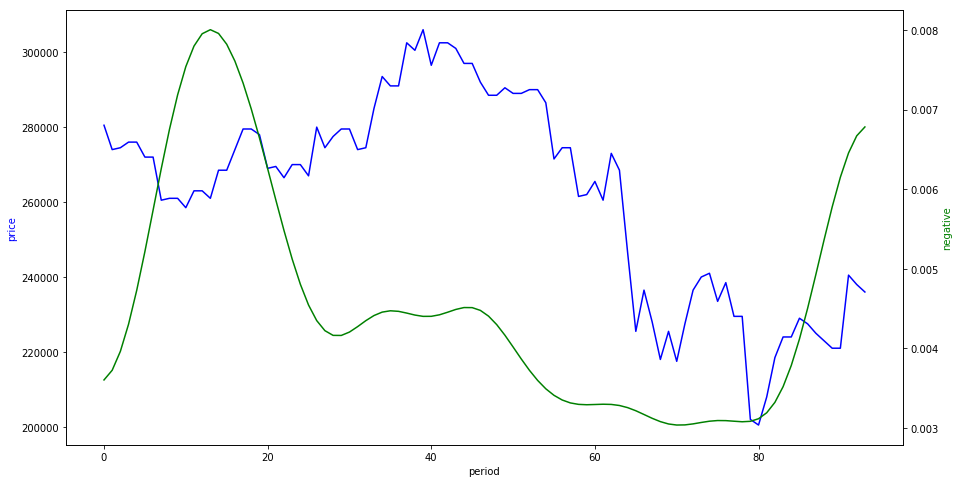

(None, None)

In [185]:
graphcal(result, 'pos_2', 'pos_prop','r-','r') , graphcal(result, 'neg_2', 'negative','g-','g')

## 주가와 긍/부정 연관 글자 수 6개 포함 게시글 수 plot

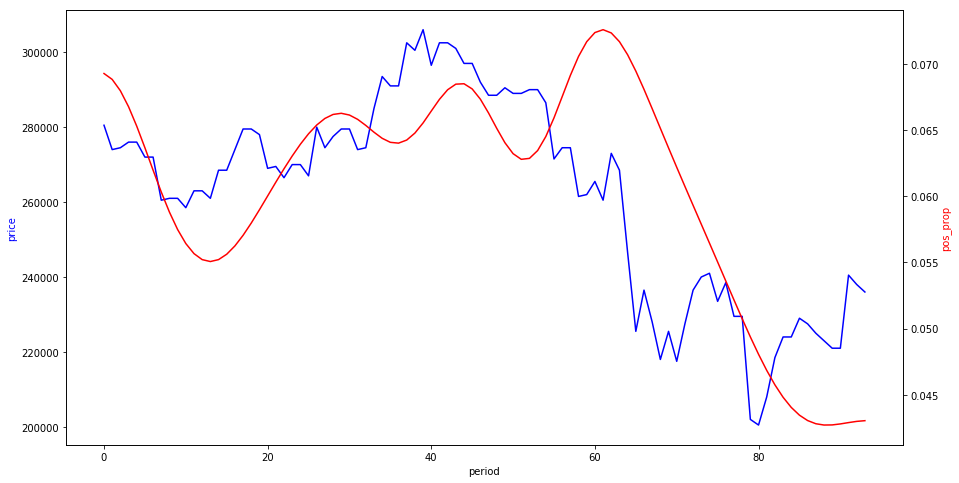

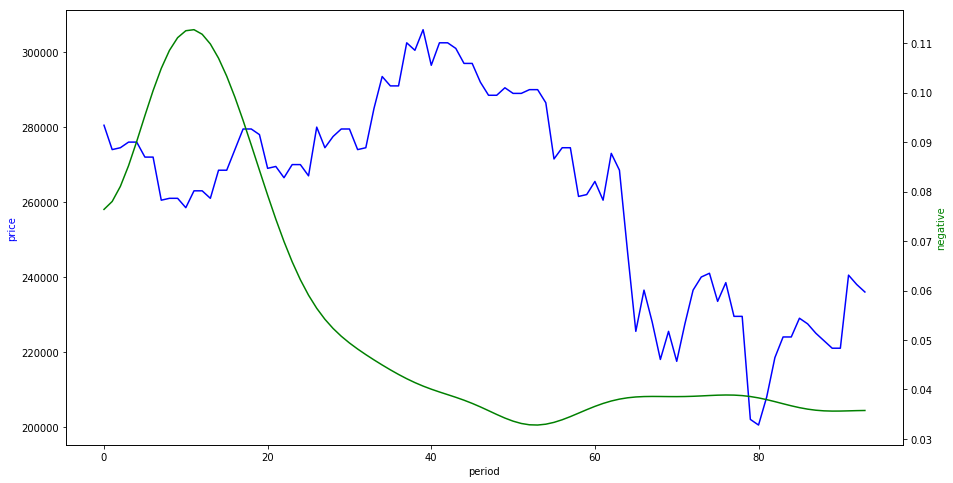

(None, None)

In [186]:
graphcal(result, 'pos_6', 'pos_prop','r-','r') , graphcal(result, 'neg_6', 'negative','g-','g')

## 주가와 긍/부정 연관 글자 수 11개 포함 게시글 수 plot

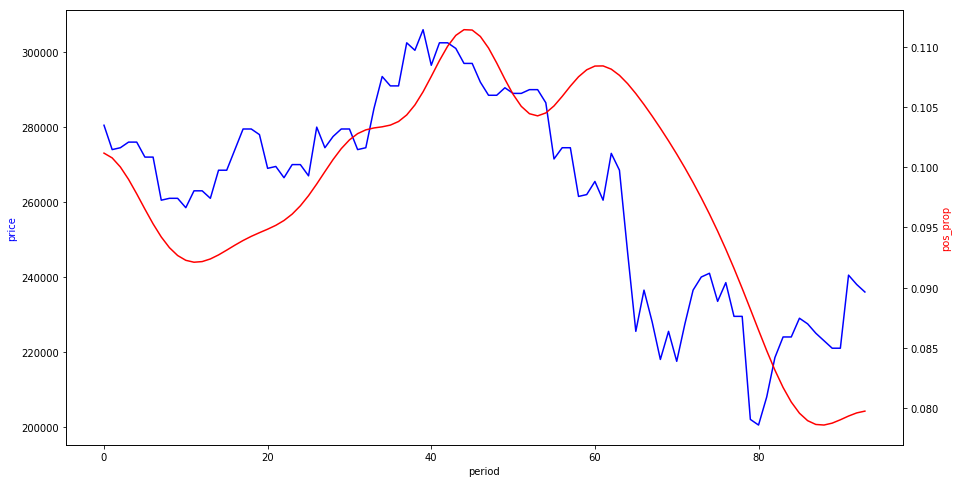

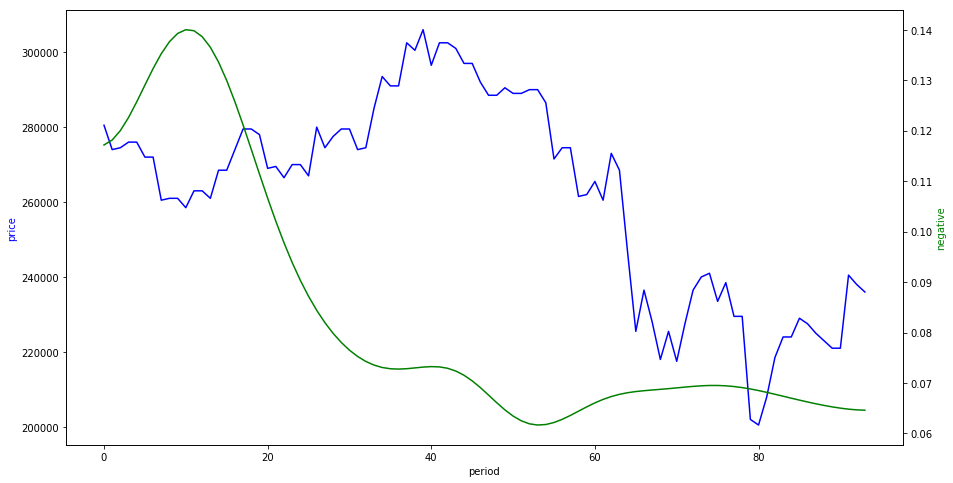

(None, None)

In [187]:
graphcal(result, 'pos_11', 'pos_prop','r-','r') , graphcal(result, 'neg_11', 'negative','g-','g')

## 주가와 긍/부정 연관 글자 수 21개 포함 게시글 수 plot

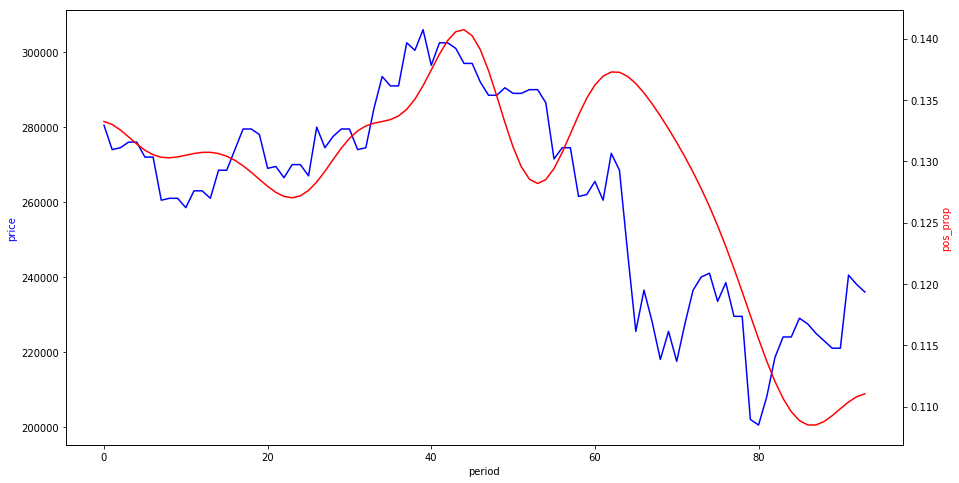

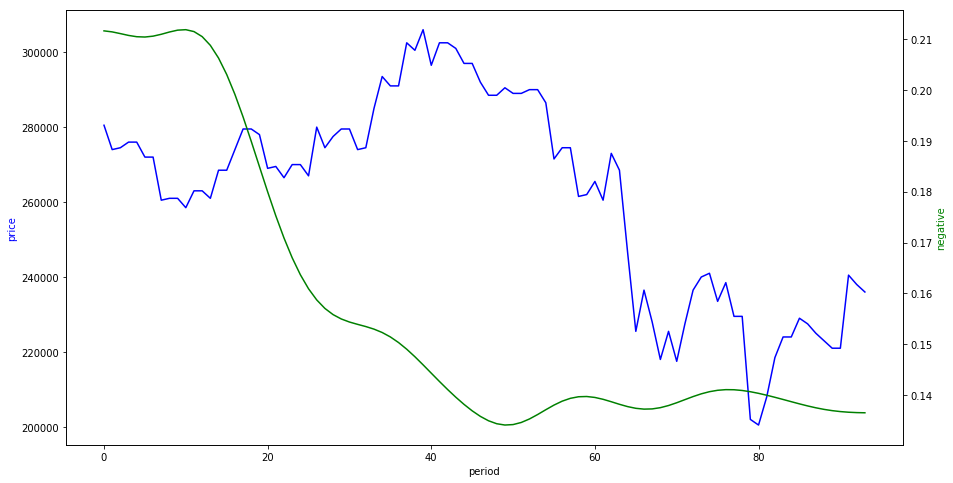

(None, None)

In [188]:
graphcal(result, 'pos_21', 'pos_prop','r-','r') , graphcal(result, 'neg_21', 'negative','g-','g')

## 주가와 긍/부정 연관 글자 수 51개 포함 게시글 수 plot

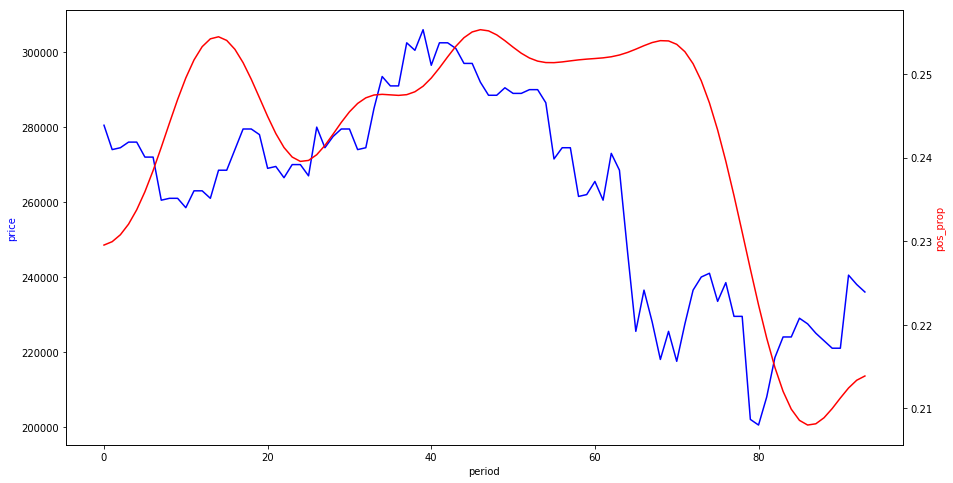

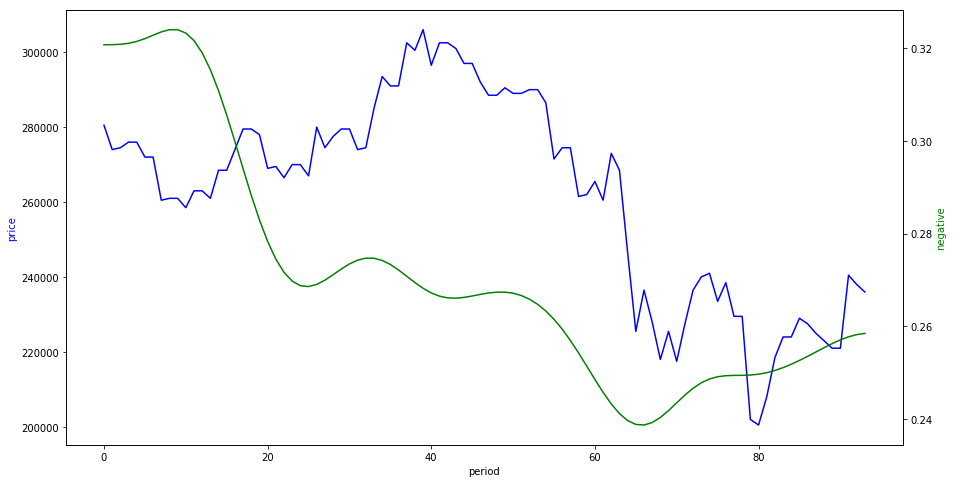

(None, None)

In [189]:
graphcal(result, 'pos_51', 'pos_prop','r-','r') , graphcal(result, 'neg_51', 'negative','g-','g')

## 주가와 긍/부정 연관 글자 수 101개 포함 게시글 수 plot

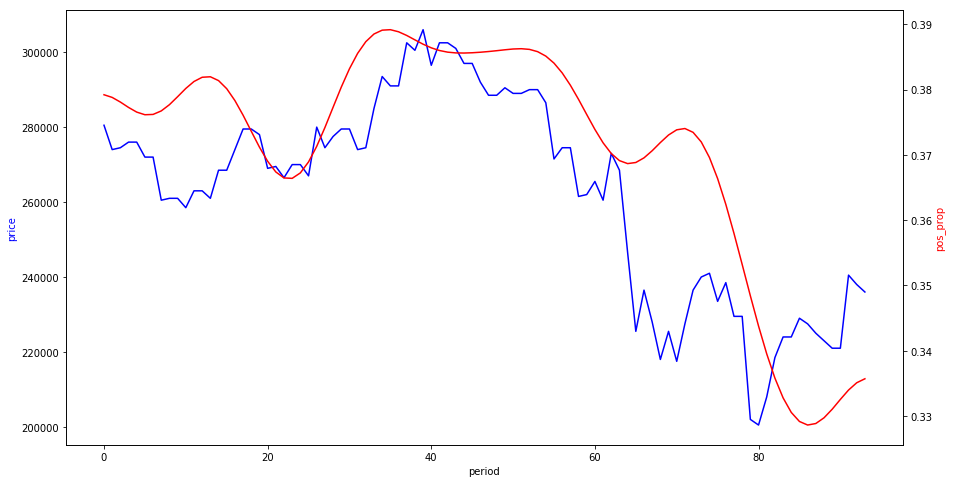

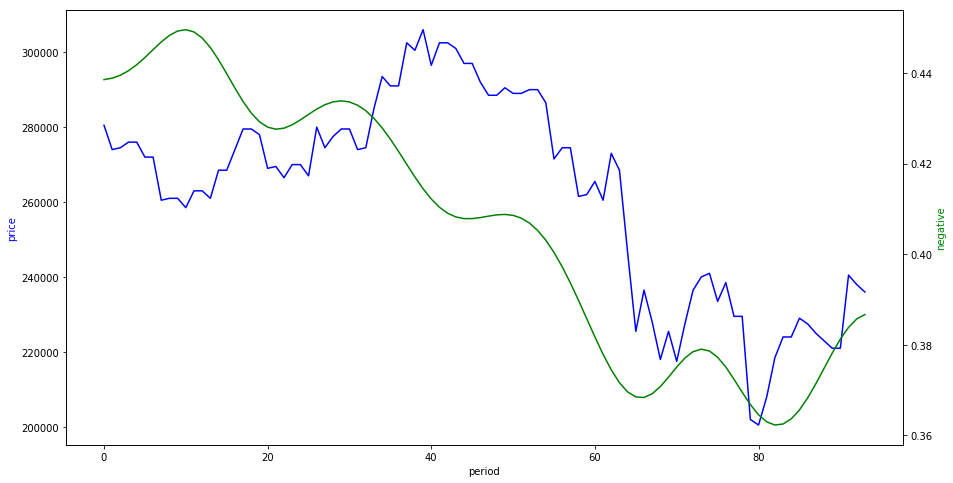

(None, None)

In [190]:
graphcal(result, 'pos_101', 'pos_prop','r-','r') , graphcal(result, 'neg_101', 'negative','g-','g')

## 주가와 긍/부정 연관 글자 수 1001개 포함 게시글 수 plot

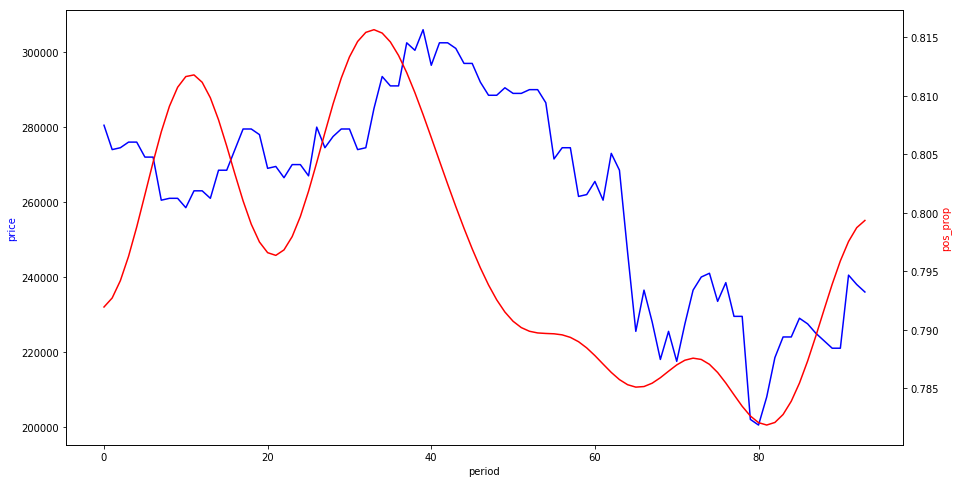

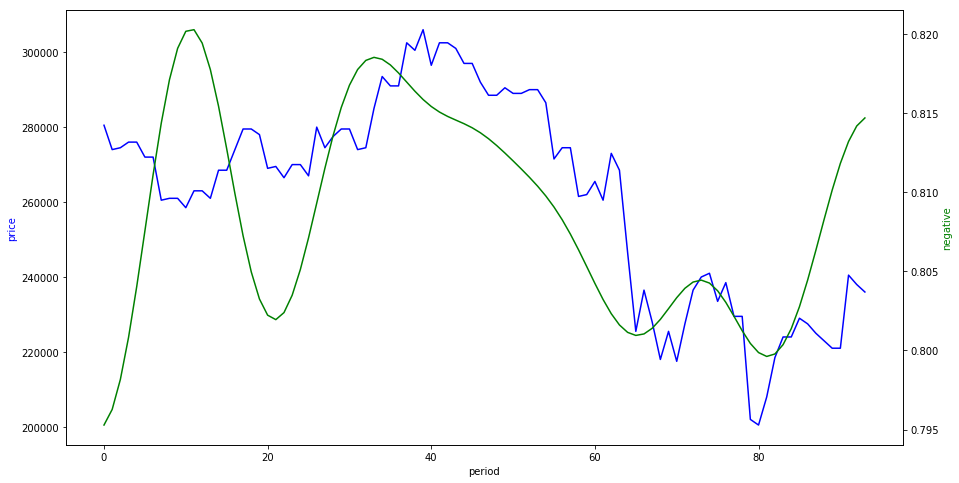

(None, None)

In [191]:
graphcal(result, 'pos_1001', 'pos_prop','r-','r') , graphcal(result, 'neg_1001', 'negative','g-','g')